---

## 1. Configuracion e Importacion de Librerias

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Configuracion visual profesional
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': [14, 8],
    'figure.dpi': 100,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# Paleta de colores
COLORES = {
    'oro': '#FFD700',
    'oro_oscuro': '#B8860B',
    'ibex': '#1E3A8A',
    'salario': '#DC2626',
    'euro': '#10B981',
    'positivo': '#22C55E',
    'negativo': '#EF4444'
}

# Directorio de salida para graficos
OUTPUT_DIR = Path('../docs/img')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

---

## 2. Carga de Datos

In [100]:
# Cargar datos exportados de la base de datos
db_export_path = "../datos/procesados/hechos_exportados_db.csv"

df_hechos = pd.read_csv(db_export_path)
df_hechos['fecha'] = pd.to_datetime(df_hechos['fecha'])

# Renombrar indicadores para consistencia
mapping = {
    'Precio Oro EUR': 'Gold_Price_EUR',
    'IBEX 35': 'IBEX35_Close',
    'Precio Oro USD': 'Gold_Price_USD',
    'Tipo Cambio EUR/USD': 'EUR_USD_ExchangeRate',
    'IPC General': 'IPC_General',
    'Salario mas frecuente': 'Salario_Frecuente',
    'Salario medio bruto': 'Salario_Medio'
}
df_hechos['indicador'] = df_hechos['indicador'].replace(mapping)

### 2.1 Resumen de Datos Cargados

In [101]:
resumen_datos = pd.DataFrame({
    'Metrica': ['Total registros', 'Periodo', 'Indicadores unicos'],
    'Valor': [
        f"{len(df_hechos):,}",
        f"{df_hechos['fecha'].min().year} - {df_hechos['fecha'].max().year}",
        df_hechos['indicador'].nunique()
    ]
})
resumen_datos.style.hide(axis='index')

Metrica,Valor
Total registros,"16,526"
Periodo,2010 - 2025
Indicadores unicos,31


---

## 3. Preparacion de Datos para Visualizaciones

### 3.1 Datos de Inflacion (IPC)

Construimos el mapa de IPC anual, incluyendo datos actualizados para 2022-2025:

| Año | Inflacion Anual | Fuente |
|------|-----------------|--------|
| 2022 | 8.4% | INE - Crisis energetica |
| 2023 | 3.5% | INE |
| 2024 | 2.8% | INE |
| 2025 | 3.0% | INE (noviembre 2025) |

In [102]:
# Extraer IPC de los datos
df_ipc = df_hechos[df_hechos['indicador'] == 'IPC_General'].copy()
df_ipc['year'] = df_ipc['fecha'].dt.year
ipc_map = df_ipc.groupby('year')['valor'].mean().to_dict()

# Actualizar con datos 2022-2025 (fuente: INE, Datosmacro)
if 2021 in ipc_map:
    base_2021 = ipc_map[2021]
    ipc_map[2022] = base_2021 * 1.084  # +8.4%
    ipc_map[2023] = ipc_map[2022] * 1.035  # +3.5%
    ipc_map[2024] = ipc_map[2023] * 1.028  # +2.8%
    ipc_map[2025] = ipc_map[2024] * 1.030  # +3.0%

# Mostrar IPC actualizado
ipc_df = pd.DataFrame([
    {'Año': year, 'Indice IPC': f"{valor:.2f}"} 
    for year, valor in sorted(ipc_map.items())
])
ipc_df.style.hide(axis='index')

Año,Indice IPC
2010,96.15
2011,98.43
2012,101.26
2013,101.51
2014,100.45
2015,100.47
2016,102.05
2017,103.18
2018,104.41
2019,105.23


### 3.2 Datos de Salarios Actualizados

| Año | Salario Medio Anual | Fuente |
|------|---------------------|--------|
| 2022 | 28,780 EUR | INE |
| 2023 | 30,250 EUR | INE |
| 2024 | 31,698 EUR | INE |
| 2025 | 33,000 EUR | Estimacion (+4.1%) |

In [103]:
# Salarios actualizados 2022-2025
SALARIOS_ACTUALIZADOS = {
    2022: 28780,
    2023: 30250,
    2024: 31698,
    2025: 33000
}

### 3.3 Crear DataFrame Pivotado por Año

In [104]:
# Agregar año y crear pivot
df_hechos['year'] = df_hechos['fecha'].dt.year
df_pivot = df_hechos.pivot_table(index='year', columns='indicador', values='valor', aggfunc='mean')

# Actualizar salarios con datos reales 2022-2025
if 'Salario_Medio' in df_pivot.columns:
    for year, sal in SALARIOS_ACTUALIZADOS.items():
        if year in df_pivot.index:
            df_pivot.loc[year, 'Salario_Medio'] = sal

# Interpolar valores faltantes
df_pivot = df_pivot.interpolate(method='linear').ffill().bfill()

# Mostrar primeras filas
df_pivot.head()

indicador,Asalariados Total,Desempleo 16-19,Desempleo 20-24,Desempleo 25-29,Desempleo 30-34,Desempleo 35-39,Desempleo 40-44,Desempleo 45-49,Desempleo 50-54,Desempleo 55-59,...,Salario Decil 30-40,Salario Decil 40-50,Salario Decil 50-60,Salario Decil 60-70,Salario Decil 70-80,Salario Decil 80-90,Salario Decil 90-100,Salario mediano,Salario_Frecuente,Salario_Medio
year,,,,,,,,,,,,,,,,,,,,,
2010,15592300.0,5.15,13.31,15.27,14.99,13.92,11.96,9.99,7.57,5.36,...,1316.05,1479.20,1667.40,1918.50,2292.05,2841.70,4309.35,18871.54,14522.79,22607.48
2011,15394200.0,4.40,13.44,14.27,15.03,13.63,12.52,10.66,8.04,5.58,...,1309.75,1484.80,1678.45,1926.10,2291.70,2847.55,4390.25,19142.20,16466.86,22717.73
2012,14573400.0,3.83,12.64,13.98,14.41,13.66,12.70,11.32,8.74,6.02,...,1322.05,1492.50,1685.25,1943.55,2303.60,2849.90,4495.55,18974.82,15512.34,22609.69
2013,14069100.0,3.50,12.21,13.40,13.81,13.70,12.62,11.88,9.30,6.59,...,1318.70,1503.05,1704.05,1979.55,2364.30,2916.45,4543.45,18911.78,16000.26,22594.87
2014,14285800.0,3.08,12.08,12.55,13.03,13.52,12.85,12.18,9.94,7.65,...,1315.50,1502.80,1714.85,1996.10,2387.00,2945.50,4554.05,19149.91,15506.82,22736.03


---

## Visualizacion 1: La Gran Divergencia - Euro vs Activos Reales

### Pregunta Clave

> **Si hubieras invertido 100 EUR en 2010, cuanto valdrian hoy segun el activo elegido?**

### Metodologia

- Todos los valores se normalizan a **Base 100** en 2010
- Se aplica **ajuste por inflacion** para mostrar el valor REAL (poder adquisitivo)
- El **Efectivo** representa guardar dinero sin invertir (pierde valor por inflacion)

### Activos Comparados

| Activo | Descripcion | Caracteristica |
|--------|-------------|----------------|
| Efectivo (Euro) | Dinero guardado sin invertir | Pierde valor por inflacion |
| Oro (EUR) | Precio de la onza en Euros | Reserva de valor historica |
| IBEX35 | Indice bursatil espanol | Renta variable |
| Salario Medio | Salario medio bruto anual | Referencia de poder adquisitivo |

In [105]:
# Preparar datos anuales
df_anual = df_hechos.groupby(['year', 'indicador'])['valor'].mean().reset_index()

# IPC base 2010
ipc_2010 = ipc_map.get(2010, 96.15)
years_range = sorted(df_pivot.index.tolist())

# Funcion para normalizar a base 100
def normalizar_serie(df, indicador_name):
    """Normaliza una serie para que empiece en 100"""
    df_ind = df[df['indicador'] == indicador_name].sort_values('year').copy()
    if not df_ind.empty:
        primer_valor = df_ind['valor'].iloc[0]
        if primer_valor != 0:
            df_ind['indice_base100'] = (df_ind['valor'] / primer_valor) * 100
        return df_ind
    return pd.DataFrame()

# Calcular efectivo ajustado por inflacion (pierde valor cada año)
efectivo_real = [(ipc_2010 / ipc_map.get(year, 100)) * 100 for year in years_range]

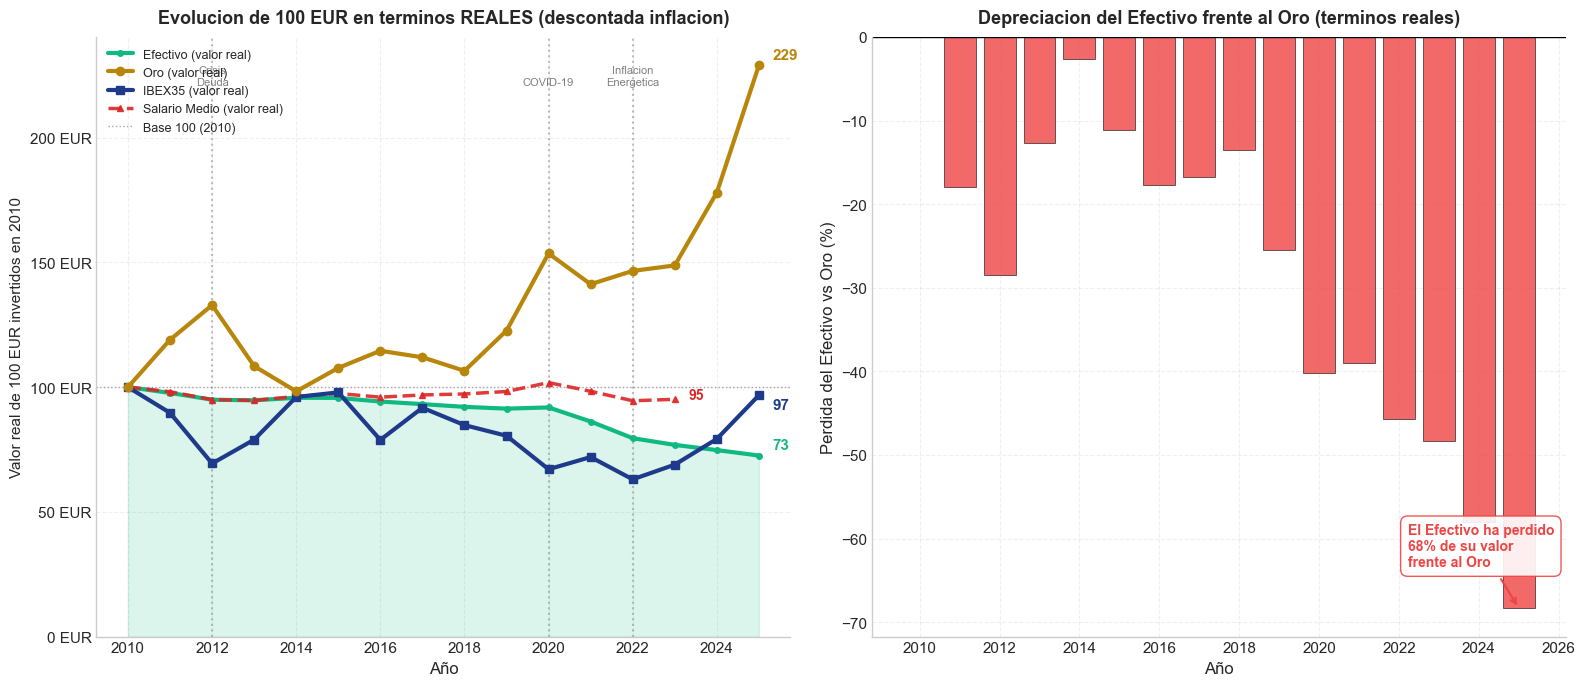


CONCLUSIONES: EVOLUCION DE 100 EUR EN TERMINOS REALES (2010-2025)


,Activo,Valor 2010,Valor 2025 (Real),Variacion,Interpretacion
0,Efectivo (Euro),100 EUR,73 EUR,-27%,Perdida de poder adquisitivo
1,Oro,100 EUR,229 EUR,+129%,Mejor reserva de valor
2,IBEX35,100 EUR,97 EUR,-3%,Crecimiento moderado
3,Salario Medio,100 EUR,95 EUR,-5%,Apenas compensa inflacion


In [ ]:
# === CREAR VISUALIZACION 1 ===
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- PANEL IZQUIERDO: Evolucion de 100 EUR ---
ax1 = axes[0]

# Efectivo (pierde valor por inflacion)
ax1.fill_between(years_range, 0, efectivo_real, alpha=0.15, color=COLORES['euro'])
ax1.plot(years_range, efectivo_real, color=COLORES['euro'], linewidth=3, 
         marker='o', markersize=4, label='Efectivo (valor real)')
ax1.annotate(f'{efectivo_real[-1]:.0f}', xy=(years_range[-1], efectivo_real[-1]),
             xytext=(10, 5), textcoords='offset points', fontsize=11, 
             fontweight='bold', color=COLORES['euro'])

# Oro
df_oro = normalizar_serie(df_anual, 'Gold_Price_EUR')
if not df_oro.empty:
    df_oro['indice_real'] = df_oro.apply(
        lambda row: row['indice_base100'] * (ipc_2010 / ipc_map.get(row['year'], 100)), axis=1)
    ax1.plot(df_oro['year'], df_oro['indice_real'], color=COLORES['oro_oscuro'], 
             linewidth=3, marker='o', markersize=6, label='Oro (valor real)', zorder=5)
    ultimo_oro = df_oro['indice_real'].iloc[-1]
    ax1.annotate(f'{ultimo_oro:.0f}', xy=(df_oro['year'].iloc[-1], ultimo_oro),
                 xytext=(10, 5), textcoords='offset points', fontsize=11,
                 fontweight='bold', color=COLORES['oro_oscuro'])

# IBEX35
df_ibex = normalizar_serie(df_anual, 'IBEX35_Close')
if not df_ibex.empty:
    df_ibex['indice_real'] = df_ibex.apply(
        lambda row: row['indice_base100'] * (ipc_2010 / ipc_map.get(row['year'], 100)), axis=1)
    ax1.plot(df_ibex['year'], df_ibex['indice_real'], color=COLORES['ibex'],
             linewidth=3, marker='s', markersize=6, label='IBEX35 (valor real)', zorder=4)
    ultimo_ibex = df_ibex['indice_real'].iloc[-1]
    ax1.annotate(f'{ultimo_ibex:.0f}', xy=(df_ibex['year'].iloc[-1], ultimo_ibex),
                 xytext=(10, -10), textcoords='offset points', fontsize=11,
                 fontweight='bold', color=COLORES['ibex'])

# Salario Medio
df_sal = normalizar_serie(df_anual, 'Salario_Medio')
if not df_sal.empty:
    df_sal['indice_real'] = df_sal.apply(
        lambda row: row['indice_base100'] * (ipc_2010 / ipc_map.get(row['year'], 100)), axis=1)
    ax1.plot(df_sal['year'], df_sal['indice_real'], color=COLORES['salario'],
             linewidth=2.5, marker='^', markersize=5, linestyle='--',
             label='Salario Medio (valor real)', alpha=0.9, zorder=3)
    ultimo_sal = df_sal['indice_real'].iloc[-1]
    ax1.annotate(f'{ultimo_sal:.0f}', xy=(df_sal['year'].iloc[-1], ultimo_sal),
                 xytext=(10, 0), textcoords='offset points', fontsize=10,
                 fontweight='bold', color=COLORES['salario'])

# Linea base 100
ax1.axhline(y=100, color='gray', linewidth=1, linestyle=':', alpha=0.7, label='Base 100 (2010)')

# Eventos economicos
eventos = {2012: 'Crisis\nDeuda', 2020: 'COVID-19', 2022: 'Inflacion\nEnergetica'}
for year, label in eventos.items():
    if year in years_range:
        ax1.axvline(x=year, color='gray', linestyle=':', alpha=0.5)
        ax1.text(year, ax1.get_ylim()[1]*0.92, label, ha='center', fontsize=8, color='gray')

ax1.set_xlabel('Año', fontsize=12)
ax1.set_ylabel('Valor real de 100 EUR invertidos en 2010', fontsize=11)
ax1.set_title('Evolucion de 100 EUR en terminos REALES (descontada inflacion)', 
              fontsize=13, fontweight='bold', pad=10)
ax1.legend(loc='upper left', framealpha=0.95, fontsize=9)
ax1.set_ylim(bottom=0)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f} EUR'))

# --- PANEL DERECHO: Perdida del Euro vs Oro ---
ax2 = axes[1]

if not df_oro.empty:
    df_comp = pd.DataFrame({'year': years_range, 'efectivo': efectivo_real})
    df_comp = df_comp.merge(df_oro[['year', 'indice_real']].rename(columns={'indice_real': 'oro'}),
                            on='year', how='left')
    df_comp['perdida_pct'] = ((df_comp['efectivo'] - df_comp['oro']) / df_comp['oro']) * 100
    
    colors_bars = [COLORES['negativo'] if x < 0 else COLORES['positivo'] for x in df_comp['perdida_pct']]
    ax2.bar(df_comp['year'], df_comp['perdida_pct'], color=colors_bars, alpha=0.8, 
            edgecolor='black', linewidth=0.5)
    
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_xlabel('Año', fontsize=12)
    ax2.set_ylabel('Perdida del Efectivo vs Oro (%)', fontsize=12)
    ax2.set_title('Depreciacion del Efectivo frente al Oro (terminos reales)', 
                  fontsize=13, fontweight='bold', pad=10)
    
    perdida_final = df_comp['perdida_pct'].iloc[-1]
    ax2.annotate(f'El Efectivo ha perdido\n{abs(perdida_final):.0f}% de su valor\nfrente al Oro', 
                 xy=(df_comp['year'].iloc[-1], perdida_final),
                 xytext=(-80, 30), textcoords='offset points',
                 fontsize=10, fontweight='bold', color=COLORES['negativo'],
                 arrowprops=dict(arrowstyle='->', color=COLORES['negativo'], lw=1.5),
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                          edgecolor=COLORES['negativo'], alpha=0.9))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'V1_divergencia_euro_activos.png', dpi=350, bbox_inches='tight', facecolor='white')
plt.show()

# Generar tabla de conclusiones
conclusiones_v1 = pd.DataFrame({
    'Activo': ['Efectivo (Euro)', 'Oro', 'IBEX35', 'Salario Medio'],
    'Valor 2010': ['100 EUR', '100 EUR', '100 EUR', '100 EUR'],
    'Valor 2025 (Real)': [
        f"{efectivo_real[-1]:.0f} EUR",
        f"{ultimo_oro:.0f} EUR" if 'ultimo_oro' in dir() else 'N/A',
        f"{ultimo_ibex:.0f} EUR" if 'ultimo_ibex' in dir() else 'N/A',
        f"{ultimo_sal:.0f} EUR" if 'ultimo_sal' in dir() else 'N/A'
    ],
    'Variacion': [
        f"{efectivo_real[-1] - 100:+.0f}%",
        f"{ultimo_oro - 100:+.0f}%" if 'ultimo_oro' in dir() else 'N/A',
        f"{ultimo_ibex - 100:+.0f}%" if 'ultimo_ibex' in dir() else 'N/A',
        f"{ultimo_sal - 100:+.0f}%" if 'ultimo_sal' in dir() else 'N/A'
    ],
    'Interpretacion': [
        'Perdida de poder adquisitivo',
        'Mejor reserva de valor',
        'Crecimiento moderado',
        'Apenas compensa inflacion'
    ]
})

print('\n' + '='*100)
print('CONCLUSIONES: EVOLUCION DE 100 EUR EN TERMINOS REALES (2010-2025)')
print('='*100)
display(conclusiones_v1)

### Insights Clave

| Hallazgo | Explicacion |
|----------|-------------|
| **El Efectivo pierde valor garantizado** | Guardar dinero sin invertir equivale a perder poder adquisitivo cada año debido a la inflacion |
| **El Oro multiplica su valor** | Ha actuado como reserva de valor efectiva, especialmente en periodos de crisis |
| **El IBEX35 apenas supera la inflacion** | La bolsa espanola ha tenido un rendimiento modesto en terminos reales |
| **Los salarios no compensan la inflacion** | El poder adquisitivo de los trabajadores se ha mantenido estancado o ha caido |

---

## Visualizacion 2: Cuantas horas de trabajo cuesta una onza de Oro?

### Pregunta Clave

> **Cuanto mas tiene que trabajar un espanol hoy para comprar la misma cantidad de Oro que en 2010?**

### Por que medir el salario en Oro?

El Oro ha sido **reserva de valor durante 5000 anios**, mientras que el Euro existe desde 1999. Medir el salario en onzas de oro revela la **inflacion oculta** que no captura el IPC oficial.

### Metodologia

| Metrica | Calculo |
|---------|---------|
| Onzas por salario anual | Salario Medio / Precio Oro EUR |
| Horas por onza | 1800 horas laborales / Onzas anuales |

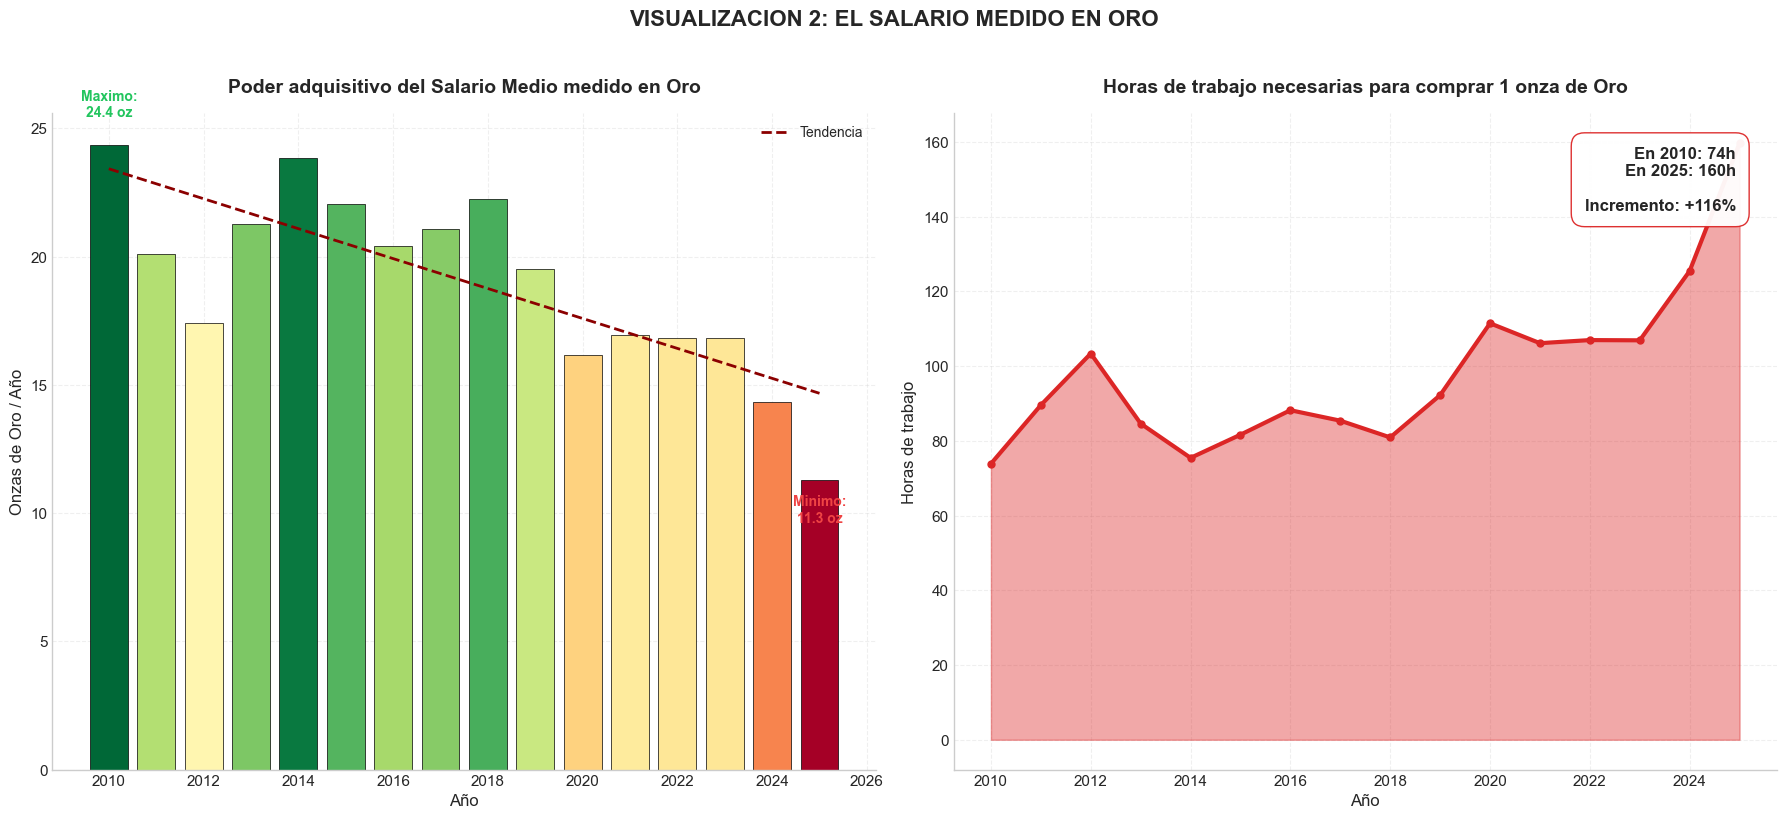


INFLACION OCULTA que no mide el IPC oficial


,Metrica,Valor
0,Onzas por salario (2010),24.4 oz
1,Onzas por salario (2025),11.3 oz
2,Perdida poder adquisitivo,-53.7%
3,Horas por onza (2010),74 h
4,Horas por onza (2025),160 h
5,Aumento esfuerzo laboral,+116%


In [107]:
# ============================================================
# VISUALIZACION 2: SALARIO REAL MEDIDO EN ORO
# ============================================================

# Preparar datos
df_pivot_viz = df_pivot.copy()

# Encontrar columnas de salario y oro
col_sal_medio = next((c for c in df_pivot_viz.columns if 'Salario_Medio' in c or 'Salario medio' in c), None)
col_oro = next((c for c in df_pivot_viz.columns if 'Gold' in c and 'EUR' in c), None)

if col_sal_medio and col_oro:
    # Calcular cuantas onzas de oro puede comprar el salario anual
    df_pivot_viz['onzas_oro_anuales'] = df_pivot_viz[col_sal_medio] / df_pivot_viz[col_oro]
    
    # Calcular horas de trabajo para comprar 1 onza (asumiendo 1800h/año laborales)
    df_pivot_viz['horas_por_onza'] = 1800 / df_pivot_viz['onzas_oro_anuales']
    
    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # ------ PANEL IZQUIERDO: Onzas de Oro que puede comprar un salario anual ------
    ax1 = axes[0]
    
    years = df_pivot_viz.index.tolist()
    onzas = df_pivot_viz['onzas_oro_anuales'].values
    
    # Degradado de colores segun la cantidad
    norm = plt.Normalize(min(onzas), max(onzas))
    colors = plt.cm.RdYlGn(norm(onzas))
    
    bars = ax1.bar(years, onzas, color=colors, edgecolor='black', linewidth=0.5)
    
    # Linea de tendencia
    z = np.polyfit(years, onzas, 1)
    p = np.poly1d(z)
    ax1.plot(years, p(years), color='darkred', linestyle='--', linewidth=2, label='Tendencia')
    
    ax1.set_xlabel('Año', fontsize=12)
    ax1.set_ylabel('Onzas de Oro / Año', fontsize=12)
    ax1.set_title('Poder adquisitivo del Salario Medio medido en Oro', fontsize=14, fontweight='bold', pad=15)
    
    # Anotar valores extremos
    max_idx = np.argmax(onzas)
    min_idx = np.argmin(onzas)
    ax1.annotate(f'Maximo:\n{onzas[max_idx]:.1f} oz', 
                 xy=(years[max_idx], onzas[max_idx]), xytext=(0, 20), 
                 textcoords='offset points', ha='center', fontsize=10, 
                 fontweight='bold', color=COLORES['positivo'])
    ax1.annotate(f'Minimo:\n{onzas[min_idx]:.1f} oz', 
                 xy=(years[min_idx], onzas[min_idx]), xytext=(0, -30), 
                 textcoords='offset points', ha='center', fontsize=10, 
                 fontweight='bold', color=COLORES['negativo'])
    
    ax1.legend(loc='upper right')
    
    # ------ PANEL DERECHO: Horas de trabajo para comprar 1 onza ------
    ax2 = axes[1]
    
    horas = df_pivot_viz['horas_por_onza'].values
    
    # Grafico de area
    ax2.fill_between(years, 0, horas, alpha=0.4, color=COLORES['salario'])
    ax2.plot(years, horas, color=COLORES['salario'], linewidth=3, marker='o', markersize=5)
    
    ax2.set_xlabel('Año', fontsize=12)
    ax2.set_ylabel('Horas de trabajo', fontsize=12)
    ax2.set_title('Horas de trabajo necesarias para comprar 1 onza de Oro', fontsize=14, fontweight='bold', pad=15)
    
    # Calcular incremento
    horas_2010 = horas[0]
    horas_final = horas[-1]
    incremento_horas = ((horas_final - horas_2010) / horas_2010) * 100
    
    # Caja de texto con conclusion
    textstr = f'En 2010: {horas_2010:.0f}h\nEn {years[-1]}: {horas_final:.0f}h\n\nIncremento: +{incremento_horas:.0f}%'
    props = dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor=COLORES['salario'], alpha=0.95)
    ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')
    
    plt.suptitle('VISUALIZACION 2: EL SALARIO MEDIDO EN ORO', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'V2_salario_en_oro.png', dpi=350, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    # --- Tabla de conclusiones ---
    perdida_poder = ((onzas[0] - onzas[-1]) / onzas[0]) * 100
    
    conclusiones_v2 = pd.DataFrame({
        'Metrica': [
            f'Onzas por salario ({years[0]})',
            f'Onzas por salario ({years[-1]})',
            'Perdida poder adquisitivo',
            f'Horas por onza ({years[0]})',
            f'Horas por onza ({years[-1]})',
            'Aumento esfuerzo laboral'
        ],
        'Valor': [
            f'{onzas[0]:.1f} oz',
            f'{onzas[-1]:.1f} oz',
            f'-{perdida_poder:.1f}%',
            f'{horas_2010:.0f} h',
            f'{horas_final:.0f} h',
            f'+{incremento_horas:.0f}%'
        ]
    })
    
    print('\n' + '='*80)
    print('INFLACION OCULTA que no mide el IPC oficial')
    print('='*80)

    display(conclusiones_v2)

---

## Visualizacion 3: Heatmap de Rendimientos Reales Anuales

### Objetivo

Mostrar el **rendimiento real (ajustado por inflacion)** de cada activo año a año. El efectivo, al no generar rendimiento pero perder poder adquisitivo por la inflacion, aparece con **valores negativos**.

### Metodologia

| Activo | Calculo Rendimiento Real |
|--------|-------------------------|
| Oro | (Precio fin año / Precio inicio año - 1) - IPC |
| IBEX35 | (Cierre fin año / Cierre inicio año - 1) - IPC |
| Efectivo | 0% - IPC = **-IPC** (perdida directa) |

> **Importante**: No se muestra el IPC como columna separada. El "Efectivo ajustado" representa lo que **realmente pierde** quien mantiene su dinero sin invertir.

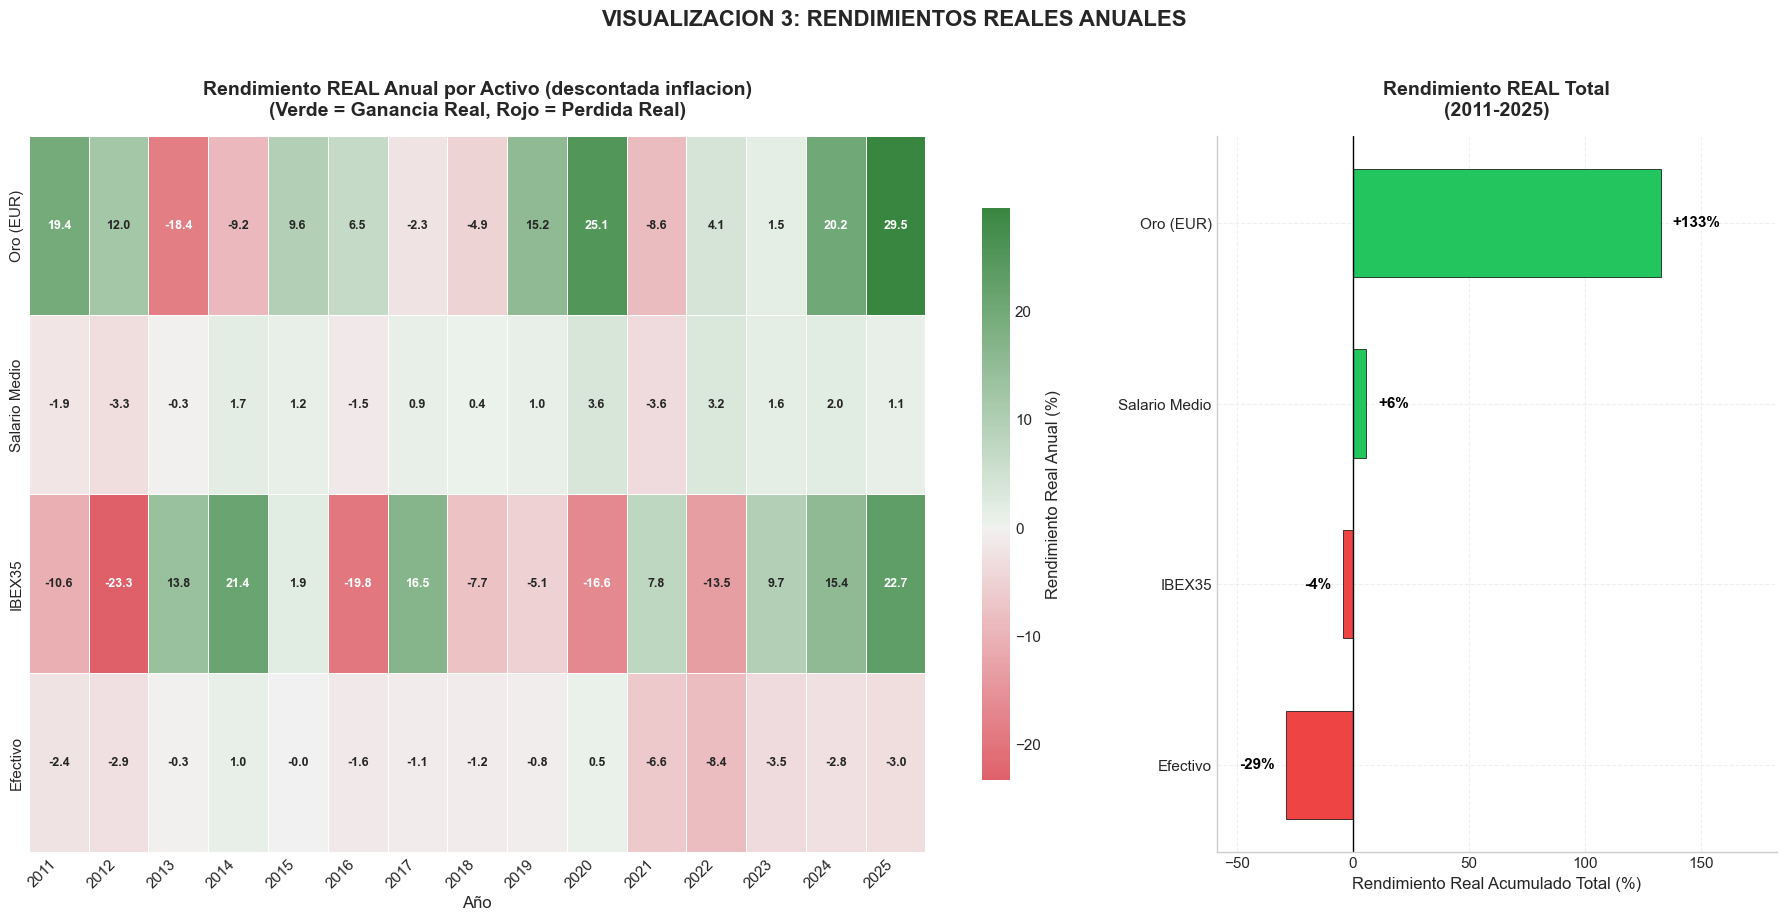


CONCLUSIONES: RENDIMIENTOS REALES POR ACTIVO


,Activo,Rendimiento Real Medio Anual,Rendimiento Acumulado Total,Años Positivos,Mejor Año,Peor Año
0,Efectivo,-2.2%,-28.6%,2 de 15,2014 (+1.0%),2022 (-8.4%)
1,IBEX35,+0.9%,-4.3%,8 de 15,2025 (+22.7%),2012 (-23.3%)
2,Salario Medio,+0.4%,+5.9%,10 de 15,2020 (+3.6%),2021 (-3.6%)
3,Oro (EUR),+6.6%,+132.7%,10 de 15,2025 (+29.5%),2013 (-18.4%)


In [ ]:
# ============================================================
# VISUALIZACION 3: HEATMAP RENDIMIENTOS REALES + BARRAS ACUMULADAS
# ============================================================

# --- Calcular rendimientos anuales REALES (ajustados por inflacion) ---
activos_clave = ['Gold_Price_EUR', 'IBEX35_Close']
activos_labels = {'Gold_Price_EUR': 'Oro (EUR)', 'IBEX35_Close': 'IBEX35'}

# Crear DataFrame de rendimientos
rendimientos = pd.DataFrame()

# Calcular inflacion anual
inflacion_anual = {}
years_sorted = sorted(ipc_map.keys())
for i, year in enumerate(years_sorted):
    if i == 0:
        inflacion_anual[year] = 0
    else:
        ipc_prev = ipc_map[years_sorted[i-1]]
        ipc_curr = ipc_map[year]
        inflacion_anual[year] = ((ipc_curr - ipc_prev) / ipc_prev) * 100

for activo in activos_clave:
    if activo in df_pivot.columns:
        # Rendimiento nominal
        rend_nominal = df_pivot[activo].pct_change() * 100
        # Rendimiento real = nominal - inflacion
        rend_real = pd.Series(index=rend_nominal.index, dtype=float)
        for year in rend_nominal.index:
            if pd.notna(rend_nominal[year]):
                infl = inflacion_anual.get(year, 0)
                rend_real[year] = rend_nominal[year] - infl
        rendimientos[activos_labels.get(activo, activo)] = rend_real

# Efectivo: pierde exactamente la inflacion
efectivo_real_anual = pd.Series(index=df_pivot.index, dtype=float)
for year in df_pivot.index:
    infl = inflacion_anual.get(year, 0)
    efectivo_real_anual[year] = -infl

rendimientos['Efectivo'] = efectivo_real_anual

# Salario real si existe
col_sal_medio = next((c for c in df_pivot.columns if 'Salario_Medio' in c), None)
if col_sal_medio and col_sal_medio in df_pivot.columns:
    rend_nominal_sal = df_pivot[col_sal_medio].pct_change() * 100
    rend_real_sal = pd.Series(index=rend_nominal_sal.index, dtype=float)
    for year in rend_nominal_sal.index:
        if pd.notna(rend_nominal_sal[year]):
            infl = inflacion_anual.get(year, 0)
            rend_real_sal[year] = rend_nominal_sal[year] - infl
    rendimientos['Salario Medio'] = rend_real_sal

# Eliminar primer año (NaN por pct_change)
rendimientos = rendimientos.dropna()

# --- Crear figura con dos paneles (como analisis_final.ipynb) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 9), gridspec_kw={'width_ratios': [2, 1]})

# ------ PANEL IZQUIERDO: Heatmap ------
ax1 = axes[0]

# Transponer para que los años esten en columnas y activos en filas
heatmap_data = rendimientos.T

# Reordenar filas: Oro, Salario Medio, IBEX35, Efectivo (mismo orden que barras)
orden_activos = ['Oro (EUR)', 'Salario Medio', 'IBEX35', 'Efectivo']
orden_activos = [a for a in orden_activos if a in heatmap_data.index]
heatmap_data = heatmap_data.reindex(orden_activos)

# Crear mapa de calor
cmap = sns.diverging_palette(10, 130, as_cmap=True)  # Rojo-Verde
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap=cmap, center=0,
            linewidths=0.5, linecolor='white', ax=ax1,
            cbar_kws={'label': 'Rendimiento Real Anual (%)', 'shrink': 0.8},
            annot_kws={'size': 9, 'weight': 'bold'})

ax1.set_title('Rendimiento REAL Anual por Activo (descontada inflacion)\n(Verde = Ganancia Real, Rojo = Perdida Real)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Año', fontsize=12)
ax1.set_ylabel('')

# Rotar etiquetas del eje X
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ------ PANEL DERECHO: Rendimiento Acumulado REAL ------
ax2 = axes[1]

# Calcular rendimiento acumulado REAL
rendimiento_acumulado = ((1 + rendimientos/100).cumprod() - 1) * 100

# Grafico de barras horizontales del rendimiento total
final_returns = rendimiento_acumulado.iloc[-1].sort_values(ascending=True)
colors_bars = [COLORES['positivo'] if x > 0 else COLORES['negativo'] for x in final_returns.values]

bars = ax2.barh(final_returns.index, final_returns.values, color=colors_bars, 
                edgecolor='black', linewidth=0.5, height=0.6)

ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('Rendimiento Real Acumulado Total (%)', fontsize=12)
ax2.set_title(f'Rendimiento REAL Total\n({rendimientos.index[0]}-{rendimientos.index[-1]})', 
              fontsize=14, fontweight='bold', pad=15)

# Anadir etiquetas de valor
for bar, val in zip(bars, final_returns.values):
    width = bar.get_width()
    ax2.text(width + 5 if width > 0 else width - 5, bar.get_y() + bar.get_height()/2,
             f'{val:+.0f}%', va='center', ha='left' if width > 0 else 'right',
             fontsize=11, fontweight='bold', color='black')

ax2.set_xlim(min(final_returns.values) - 30, max(final_returns.values) + 50)

plt.suptitle('VISUALIZACION 3: RENDIMIENTOS REALES ANUALES', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'V3_heatmap_rendimientos_reales.png', dpi=350, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# --- Tabla de conclusiones (pandas sin formato especial) ---
conclusiones_v3 = pd.DataFrame({
    'Activo': list(final_returns.index),
    'Rendimiento Real Medio Anual': [f"{heatmap_data.loc[act].mean():+.1f}%" for act in final_returns.index],
    'Rendimiento Acumulado Total': [f"{val:+.1f}%" for val in final_returns.values],
    'Años Positivos': [f"{(heatmap_data.loc[act] > 0).sum()} de {len(heatmap_data.columns)}" for act in final_returns.index],
    'Mejor Año': [f"{heatmap_data.loc[act].idxmax()} ({heatmap_data.loc[act].max():+.1f}%)" for act in final_returns.index],
    'Peor Año': [f"{heatmap_data.loc[act].idxmin()} ({heatmap_data.loc[act].min():+.1f}%)" for act in final_returns.index]
})

print('\n' + '='*100)
print('CONCLUSIONES: RENDIMIENTOS REALES POR ACTIVO')
print('='*100)
display(conclusiones_v3)

---

## Visualizacion 4: Simulacion de Patrimonio por Clase Social

### Escenario de Simulacion

Simulamos como evoluciona el patrimonio de tres perfiles de inversor espanol desde 2010 hasta 2025, asumiendo que cada uno invierte sus ahorros anuales en diferentes activos.

### Perfiles Simulados

| Perfil | Ahorro Anual (% salario) | Estrategia |
|--------|--------------------------|------------|
| **Clase Baja** (Decil 1) | 5% del salario | 100% Efectivo (bajo colchon) |
| **Clase Media** (Decil 5) | 15% del salario | 50% Cash + 25% IBEX + 25% Oro |
| **Clase Alta** (Decil 9) | 30% del salario | 20% Cash + 40% Oro + 40% IBEX |

### Objetivo

Demostrar como la **estrategia de inversion** y el **acceso a activos reales** amplifica la desigualdad economica.

In [109]:
# ============================================================
# VISUALIZACION 4: SIMULACION POR CLASE SOCIAL
# ============================================================

# --- Cargar datos de salarios por deciles ---
path_deciles = Path('../datos/procesados/Salarios/Salario_mensual_deciles_ 2010_2023.csv')
df_deciles_raw = pd.read_csv(path_deciles, sep=';', encoding='utf-8')

# Extraer año de la fecha y pivotar
df_deciles_raw['year'] = pd.to_datetime(df_deciles_raw['Fecha']).dt.year
df_deciles_pivot = df_deciles_raw.pivot_table(index='Decil', columns='year', values='Valor', aggfunc='mean')

# Mapear deciles a nombres
DECIL_MAP = {
    '0-10': 'Decil 1',
    '10-20': 'Decil 2', 
    '20-30': 'Decil 3',
    '30-40': 'Decil 4',
    '40-50': 'Decil 5',
    '50-60': 'Decil 6',
    '60-70': 'Decil 7',
    '70-80': 'Decil 8',
    '80-90': 'Decil 9',
    '90-100': 'Decil 10'
}
df_deciles_pivot.index = df_deciles_pivot.index.map(lambda x: DECIL_MAP.get(x, x))

# Convertir mensual a anual (x14 pagas)
df_deciles_anual = df_deciles_pivot * 14

# Extrapolar 2024 y 2025 (+5% anual)
ultimo_año = df_deciles_anual.columns.max()
for year in [2024, 2025]:
    if year not in df_deciles_anual.columns:
        prev_year = year - 1 if (year - 1) in df_deciles_anual.columns else ultimo_año
        df_deciles_anual[year] = df_deciles_anual[prev_year] * 1.05

# --- Definir perfiles ---
PERFILES = {
    'Clase Baja (D1)': {
        'decil': 'Decil 1',
        'tasa_ahorro': 0.05,
        'asignacion': {'efectivo': 1.0, 'ibex': 0.0, 'oro': 0.0},
        'color': COLORES['euro']
    },
    'Clase Media (D5)': {
        'decil': 'Decil 5',
        'tasa_ahorro': 0.15,
        'asignacion': {'efectivo': 0.50, 'ibex': 0.25, 'oro': 0.25},
        'color': COLORES['ibex']
    },
    'Clase Alta (D9)': {
        'decil': 'Decil 9',
        'tasa_ahorro': 0.30,
        'asignacion': {'efectivo': 0.20, 'ibex': 0.40, 'oro': 0.40},
        'color': COLORES['oro']
    }
}

# --- Calcular rendimientos anuales de cada activo ---
# Rendimiento del Oro
rend_oro_anual = {}
col_oro = 'Gold_Price_EUR'
if col_oro in df_pivot.columns:
    for i, year in enumerate(df_pivot.index):
        if i == 0:
            rend_oro_anual[year] = 0
        else:
            prev_year = df_pivot.index[i-1]
            rend_oro_anual[year] = (df_pivot.loc[year, col_oro] / df_pivot.loc[prev_year, col_oro]) - 1

# Rendimiento del IBEX35
rend_ibex_anual = {}
col_ibex = 'IBEX35_Close'
if col_ibex in df_pivot.columns:
    for i, year in enumerate(df_pivot.index):
        if i == 0:
            rend_ibex_anual[year] = 0
        else:
            prev_year = df_pivot.index[i-1]
            rend_ibex_anual[year] = (df_pivot.loc[year, col_ibex] / df_pivot.loc[prev_year, col_ibex]) - 1

# --- Obtener rendimientos anuales ---
def obtener_rendimiento(activo, año):
    """Obtiene el rendimiento de un activo en un año dado."""
    if activo == 'efectivo':
        # El efectivo pierde por inflacion
        infl = inflacion_anual.get(año, 3.0)
        return -infl / 100  # Rendimiento negativo igual a la inflacion
    elif activo == 'ibex':
        return rend_ibex_anual.get(año, 0.05)
    elif activo == 'oro':
        return rend_oro_anual.get(año, 0.08)
    return 0

# --- Simular evolucion del patrimonio ---
def simular_patrimonio(perfil_config, años):
    """Simula la evolucion del patrimonio para un perfil."""
    patrimonio = 0
    patrimonio_nominal = 0
    historico = []
    historico_nominal = []
    
    for año in años:
        # Obtener salario del decil
        if año in df_deciles_anual.columns:
            decil = perfil_config['decil']
            if decil in df_deciles_anual.index:
                salario = df_deciles_anual.loc[decil, año]
            else:
                continue
        else:
            continue
        
        # Ahorro anual
        ahorro = salario * perfil_config['tasa_ahorro']
        
        # Rendimiento del patrimonio existente
        rendimiento_total = 0
        for activo, peso in perfil_config['asignacion'].items():
            if peso > 0:
                rend = obtener_rendimiento(activo, año)
                rendimiento_total += peso * rend
        
        # Actualizar patrimonio real
        patrimonio = patrimonio * (1 + rendimiento_total) + ahorro
        
        # Patrimonio nominal (sin ajuste, solo ahorro acumulado)
        patrimonio_nominal += ahorro
        
        historico.append({'año': año, 'patrimonio': patrimonio})
        historico_nominal.append({'año': año, 'patrimonio': patrimonio_nominal})
    
    return pd.DataFrame(historico), pd.DataFrame(historico_nominal)

# --- Ejecutar simulacion ---
años = list(range(2010, 2026))
resultados = {}
resultados_nominal = {}

for nombre, config in PERFILES.items():
    df_real, df_nominal = simular_patrimonio(config, años)
    resultados[nombre] = df_real
    resultados_nominal[nombre] = df_nominal

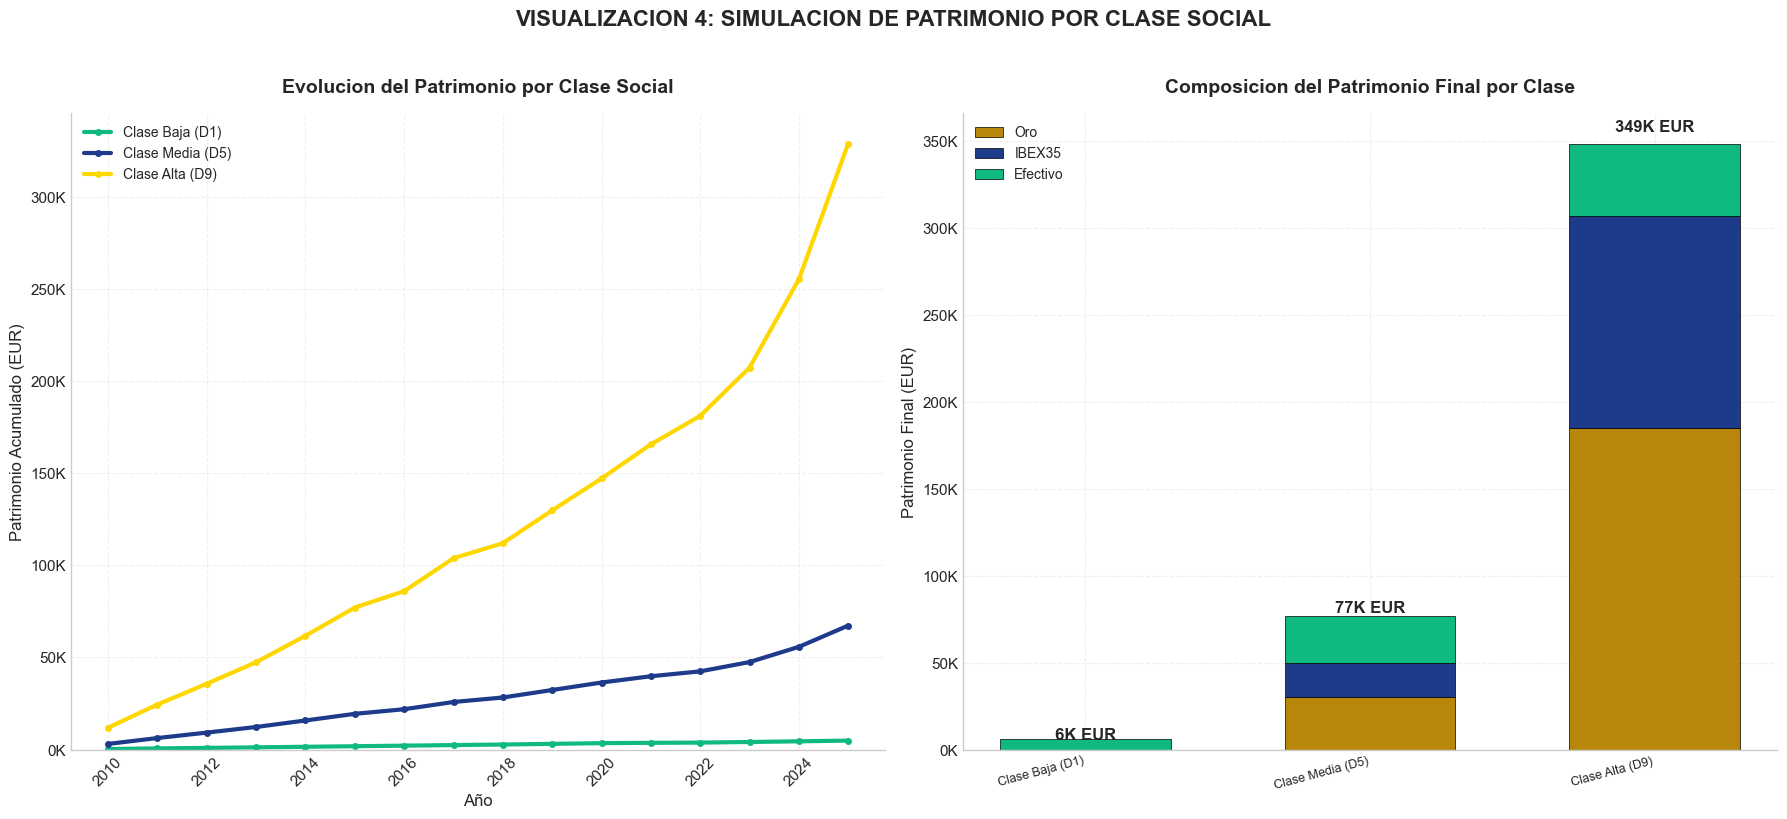


RESUMEN: IMPACTO DE LA ESTRATEGIA DE INVERSION


,Perfil,Decil,Tasa Ahorro,Ahorro Acumulado,Patrimonio Final,Diferencia,Estrategia
0,Clase Baja (D1),Decil 1,5%,5 920 EUR,4 888 EUR,-1 032 EUR,0% Oro + 0% IBEX + 100% Cash
1,Clase Media (D5),Decil 5,15%,54 275 EUR,67 313 EUR,+13 038 EUR,25% Oro + 25% IBEX + 50% Cash
2,Clase Alta (D9),Decil 9,30%,207 680 EUR,328 811 EUR,+121 131 EUR,40% Oro + 40% IBEX + 20% Cash


In [ ]:
# --- GRAFICO DOBLE: Evolucion Patrimonio + Composicion Final (como analisis_final.ipynb) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ------ PANEL 1: Evolucion temporal del patrimonio ------
ax1 = axes[0]

for nombre, config in PERFILES.items():
    df_res = resultados[nombre]
    ax1.plot(df_res['año'], df_res['patrimonio'], 
             linewidth=3, label=nombre, color=config['color'], marker='o', markersize=4)

ax1.set_xlabel('Año', fontsize=12)
ax1.set_ylabel('Patrimonio Acumulado (EUR)', fontsize=12)
ax1.set_title('Evolucion del Patrimonio por Clase Social', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=10)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1000:,.0f}K'))
ax1.set_ylim(bottom=0)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(anios[::2])
ax1.tick_params(axis='x', rotation=45)

# ------ PANEL 2: Composicion del patrimonio final (barras apiladas) ------
ax2 = axes[1]

# Necesitamos obtener la composicion del patrimonio (oro, ibex, efectivo)
# Recalculamos con una simulacion que guarde los componentes
nombres = list(PERFILES.keys())
valores_oro = []
valores_ibex = []
valores_cash = []

# Simular con detalle de composicion
for nombre, config in PERFILES.items():
    decil = config['decil']
    tasa = config['tasa_ahorro']
    asig = config['asignacion']
    
    gold_units, ibex_units, cash = 0, 0, 0
    col_gold = 'Gold_Price_EUR'
    col_ibex = 'IBEX35_Close'
    
    for año in anios:
        if año in df_deciles_anual.columns and decil in df_deciles_anual.index:
            salario = df_deciles_anual.loc[decil, año]
            ahorro = salario * tasa
            
            # Invertir segun asignacion
            if asig.get('oro', 0) > 0 and año in df_pivot.index and col_gold in df_pivot.columns:
                precio_oro = df_pivot.loc[año, col_gold]
                if precio_oro > 0:
                    gold_units += (ahorro * asig['oro']) / precio_oro
            
            if asig.get('ibex', 0) > 0 and año in df_pivot.index and col_ibex in df_pivot.columns:
                precio_ibex = df_pivot.loc[año, col_ibex]
                if precio_ibex > 0:
                    ibex_units += (ahorro * asig['ibex']) / precio_ibex
            
            cash += ahorro * asig.get('efectivo', 0)
    
    # Valorar al precio final
    ultimo_año = max(años)
    precio_oro_final = df_pivot.loc[ultimo_año, col_gold] if ultimo_año in df_pivot.index else 0
    precio_ibex_final = df_pivot.loc[ultimo_año, col_ibex] if ultimo_año in df_pivot.index else 0
    
    valores_oro.append(gold_units * precio_oro_final)
    valores_ibex.append(ibex_units * precio_ibex_final)
    valores_cash.append(cash)

x = np.arange(len(nombres))
width = 0.6

ax2.bar(x, valores_oro, width, label='Oro', color=COLORES['oro_oscuro'], edgecolor='black', linewidth=0.5)
ax2.bar(x, valores_ibex, width, bottom=valores_oro, label='IBEX35', color=COLORES['ibex'], edgecolor='black', linewidth=0.5)
ax2.bar(x, valores_cash, width, bottom=np.array(valores_oro)+np.array(valores_ibex), 
        label='Efectivo', color=COLORES['euro'], edgecolor='black', linewidth=0.5)

ax2.set_ylabel('Patrimonio Final (EUR)', fontsize=12)
ax2.set_title('Composicion del Patrimonio Final por Clase', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(nombres, rotation=15, ha='right', fontsize=9)
ax2.legend(loc='upper left')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Anadir valores totales encima de las barras (formato XK EUR mas grande)
for i, (oro, ibex, cash) in enumerate(zip(valores_oro, valores_ibex, valores_cash)):
    total = oro + ibex + cash
    ax2.text(i, total + total*0.02, f'{total/1000:.0f}K EUR', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('VISUALIZACION 4: SIMULACION DE PATRIMONIO POR CLASE SOCIAL', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'V4_simulacion_patrimonio.png', dpi=350, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# --- Funcion para formato con espacio como separador de miles ---
def formato_miles(valor):
    """Formatea un numero con espacio como separador de miles"""
    return f"{valor:,.0f}".replace(",", " ")

# --- Tabla resumen (pandas sin formato) ---
tabla_v4 = pd.DataFrame({
    'Perfil': nombres,
    'Decil': [PERFILES[n]['decil'] for n in nombres],
    'Tasa Ahorro': [f"{PERFILES[n]['tasa_ahorro']*100:.0f}%" for n in nombres],
    'Ahorro Acumulado': [f"{formato_miles(resultados_nominal[n].iloc[-1]['patrimonio'])} EUR" for n in nombres],
    'Patrimonio Final': [f"{formato_miles(resultados[n].iloc[-1]['patrimonio'])} EUR" for n in nombres],
    'Diferencia': [f"{'+' if resultados[n].iloc[-1]['patrimonio'] - resultados_nominal[n].iloc[-1]['patrimonio'] >= 0 else ''}{formato_miles(resultados[n].iloc[-1]['patrimonio'] - resultados_nominal[n].iloc[-1]['patrimonio'])} EUR" for n in nombres],
    'Estrategia': [f"{PERFILES[n]['asignacion'].get('oro',0)*100:.0f}% Oro + {PERFILES[n]['asignacion'].get('ibex',0)*100:.0f}% IBEX + {PERFILES[n]['asignacion'].get('efectivo',0)*100:.0f}% Cash" for n in nombres]
})

print('\n' + '='*120)
print('RESUMEN: IMPACTO DE LA ESTRATEGIA DE INVERSION')
print('='*120)
display(tabla_v4)

---

## Visualizacion 5: Brechas de Desigualdad

### Objetivo

Analizar dos tipos de desigualdad:

1. **Brecha Salarial**: Diferencia de ingresos entre los que mas ganan (Decil 9) y los que menos (Decil 1)
2. **Brecha Patrimonial**: Diferencia de patrimonio acumulado entre clases sociales, amplificada por las estrategias de inversion

### Hipotesis

> La brecha patrimonial crece mas rapido que la brecha salarial porque las clases altas tienen acceso a activos que se revalorizan (Oro, Bolsa), mientras que las clases bajas solo pueden ahorrar en efectivo que pierde valor por la inflacion.

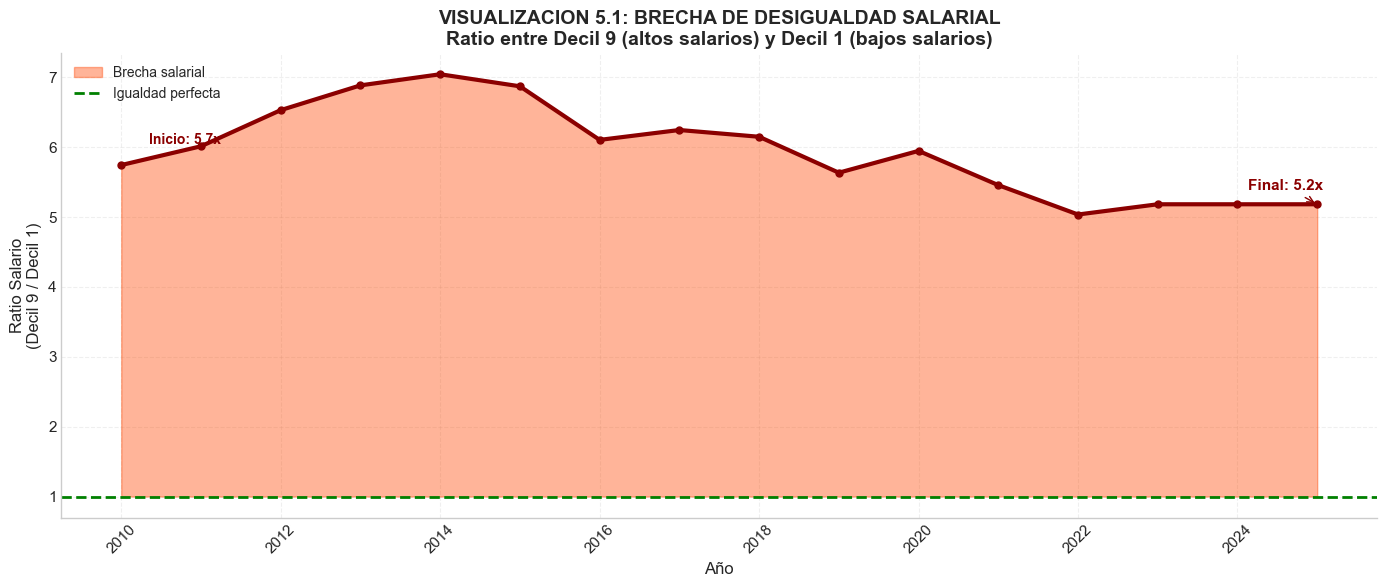


CONCLUSIONES: LA BRECHA DE DESIGUALDAD SALARIAL


,Metrica,Valor
0,Brecha salarial inicial (2010),5.7x
1,Brecha salarial final (2025),5.2x
2,Variacion de la brecha,-9.8%
3,Salario Decil 9 (2025),"52,339 EUR/año"
4,Salario Decil 1 (2025),"10,099 EUR/año"
5,Diferencia salarial absoluta,"42,239 EUR/año"


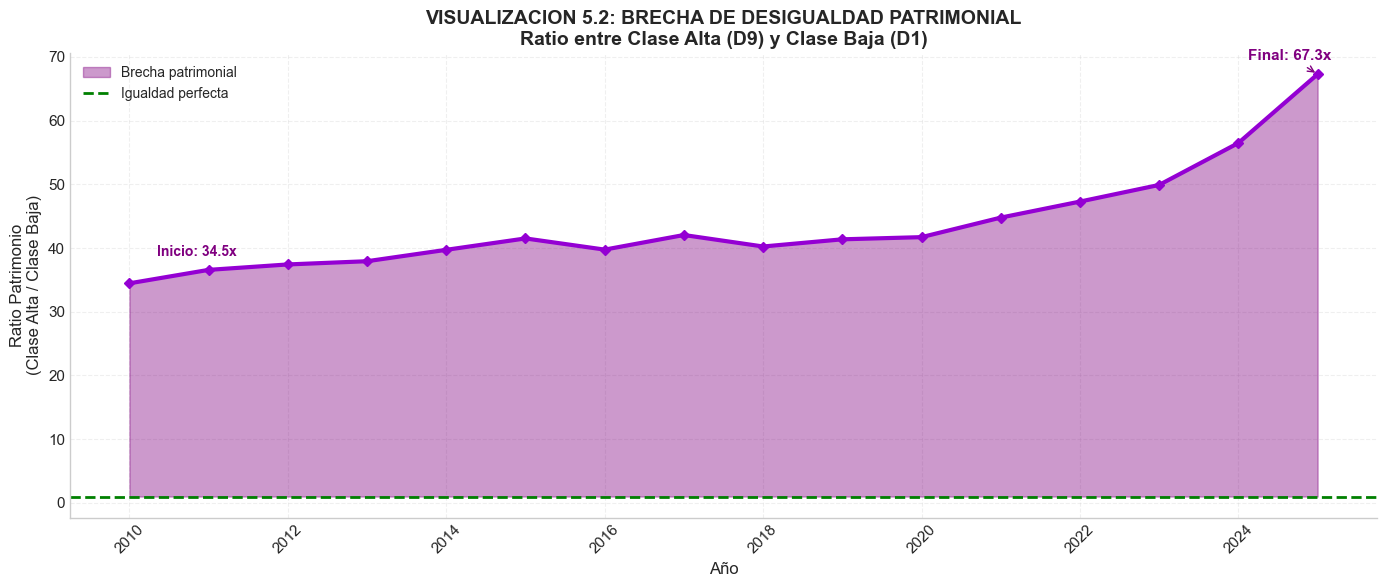


CONCLUSIONES: LA BRECHA DE DESIGUALDAD PATRIMONIAL


,Metrica,Valor
0,Brecha patrimonial inicial (2010),34.5x
1,Brecha patrimonial final (2025),67.3x
2,Aumento de la desigualdad,+95%
3,Patrimonio Clase Alta (2025),"328,811 EUR"
4,Patrimonio Clase Baja (2025),"4,888 EUR"
5,Diferencia absoluta,"323,923 EUR"


In [ ]:
# ============================================================
# VISUALIZACION 5: BRECHAS DE DESIGUALDAD (SALARIAL Y PATRIMONIAL)
# ============================================================

# --- GRAFICO 1: BRECHA DE DESIGUALDAD SALARIAL ---
fig, ax = plt.subplots(figsize=(14, 6))

# Calcular brecha salarial: ratio entre Decil 9 y Decil 1
brecha_salarial = []
for año in anios:
    if año in df_deciles_anual.columns:
        salario_d9 = df_deciles_anual.loc['Decil 9', año] if 'Decil 9' in df_deciles_anual.index else 0
        salario_d1 = df_deciles_anual.loc['Decil 1', año] if 'Decil 1' in df_deciles_anual.index else 1
        if salario_d1 > 0:
            ratio_sal = salario_d9 / salario_d1
        else:
            ratio_sal = 1
        brecha_salarial.append({'año': año, 'ratio': ratio_sal, 'salario_d9': salario_d9, 'salario_d1': salario_d1})

df_brecha_sal = pd.DataFrame(brecha_salarial)

# Grafico de area
ax.fill_between(df_brecha_sal['año'], 1, df_brecha_sal['ratio'], 
                alpha=0.4, color='orangered', label='Brecha salarial')
ax.plot(df_brecha_sal['año'], df_brecha_sal['ratio'], 
        color='darkred', linewidth=3, marker='o', markersize=5)

# Linea de referencia (igualdad)
ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Igualdad perfecta')

ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Ratio Salario\n(Decil 9 / Decil 1)', fontsize=12)
ax.set_title('VISUALIZACION 5.1: BRECHA DE DESIGUALDAD SALARIAL\nRatio entre Decil 9 (altos salarios) y Decil 1 (bajos salarios)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Anotaciones
ratio_sal_inicio = df_brecha_sal.iloc[0]['ratio']
ratio_sal_fin = df_brecha_sal.iloc[-1]['ratio']
ax.annotate(f'Inicio: {ratio_sal_inicio:.1f}x', 
            xy=(df_brecha_sal.iloc[0]['año'], ratio_sal_inicio),
            xytext=(20, 15), textcoords='offset points',
            fontsize=10, fontweight='bold', color='darkred')
ax.annotate(f'Final: {ratio_sal_fin:.1f}x', 
            xy=(df_brecha_sal.iloc[-1]['año'], ratio_sal_fin),
            xytext=(-50, 10), textcoords='offset points',
            fontsize=11, fontweight='bold', color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred'))

ax.set_xticks(anios[::2])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'V5_brecha_desigualdad_salarial.png', dpi=350, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# --- Tabla conclusiones brecha salarial (pandas sin formato) ---
conclusiones_brecha_sal = pd.DataFrame({
    'Metrica': [
        'Brecha salarial inicial (2010)',
        'Brecha salarial final (2025)',
        'Variacion de la brecha',
        'Salario Decil 9 (2025)',
        'Salario Decil 1 (2025)',
        'Diferencia salarial absoluta'
    ],
    'Valor': [
        f'{ratio_sal_inicio:.1f}x',
        f'{ratio_sal_fin:.1f}x',
        f'{((ratio_sal_fin - ratio_sal_inicio) / ratio_sal_inicio * 100):+.1f}%',
        f"{df_brecha_sal.iloc[-1]['salario_d9']:,.0f} EUR/año",
        f"{df_brecha_sal.iloc[-1]['salario_d1']:,.0f} EUR/año",
        f"{df_brecha_sal.iloc[-1]['salario_d9'] - df_brecha_sal.iloc[-1]['salario_d1']:,.0f} EUR/año"
    ]
})

print('\n' + '='*80)
print('CONCLUSIONES: LA BRECHA DE DESIGUALDAD SALARIAL')
print('='*80)
display(conclusiones_brecha_sal)

# --- GRAFICO 2: BRECHA DE DESIGUALDAD PATRIMONIAL ---
fig, ax = plt.subplots(figsize=(14, 6))

# Calcular brecha: ratio entre clase alta y clase baja
brecha_historico = []
for i, año in enumerate(anios):
    if i < len(resultados['Clase Alta (D9)']) and i < len(resultados['Clase Baja (D1)']):
        patrimonio_alta = resultados['Clase Alta (D9)'].iloc[i]['patrimonio']
        patrimonio_baja = resultados['Clase Baja (D1)'].iloc[i]['patrimonio']
        if patrimonio_baja > 0:
            ratio = patrimonio_alta / patrimonio_baja
        else:
            ratio = 1
        brecha_historico.append({'año': año, 'ratio': ratio})

df_brecha = pd.DataFrame(brecha_historico)

# Grafico de area con gradiente
ax.fill_between(df_brecha['año'], 1, df_brecha['ratio'], 
                alpha=0.4, color='purple', label='Brecha patrimonial')
ax.plot(df_brecha['año'], df_brecha['ratio'], 
        color='darkviolet', linewidth=3, marker='D', markersize=5)

# Linea de referencia (igualdad)
ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Igualdad perfecta')

ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Ratio Patrimonio\n(Clase Alta / Clase Baja)', fontsize=12)
ax.set_title('VISUALIZACION 5.2: BRECHA DE DESIGUALDAD PATRIMONIAL\nRatio entre Clase Alta (D9) y Clase Baja (D1)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Anotaciones
ratio_inicio = df_brecha.iloc[0]['ratio']
ratio_fin = df_brecha.iloc[-1]['ratio']
ax.annotate(f'Inicio: {ratio_inicio:.1f}x', 
            xy=(df_brecha.iloc[0]['año'], ratio_inicio),
            xytext=(20, 20), textcoords='offset points',
            fontsize=10, fontweight='bold', color='purple')
ax.annotate(f'Final: {ratio_fin:.1f}x', 
            xy=(df_brecha.iloc[-1]['año'], ratio_fin),
            xytext=(-50, 10), textcoords='offset points',
            fontsize=11, fontweight='bold', color='purple',
            arrowprops=dict(arrowstyle='->', color='purple'))

ax.set_xticks(anios[::2])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'V5_brecha_desigualdad_patrimonial.png', dpi=350, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# --- Tabla conclusiones brecha patrimonial (pandas sin formato) ---
conclusiones_brecha = pd.DataFrame({
    'Metrica': [
        'Brecha patrimonial inicial (2010)',
        'Brecha patrimonial final (2025)',
        'Aumento de la desigualdad',
        'Patrimonio Clase Alta (2025)',
        'Patrimonio Clase Baja (2025)',
        'Diferencia absoluta'
    ],
    'Valor': [
        f'{ratio_inicio:.1f}x',
        f'{ratio_fin:.1f}x',
        f'+{((ratio_fin - ratio_inicio) / ratio_inicio * 100):.0f}%',
        f"{resultados['Clase Alta (D9)'].iloc[-1]['patrimonio']:,.0f} EUR",
        f"{resultados['Clase Baja (D1)'].iloc[-1]['patrimonio']:,.0f} EUR",
        f"{resultados['Clase Alta (D9)'].iloc[-1]['patrimonio'] - resultados['Clase Baja (D1)'].iloc[-1]['patrimonio']:,.0f} EUR"
    ]
})

print('\n' + '='*80)
print('CONCLUSIONES: LA BRECHA DE DESIGUALDAD PATRIMONIAL')
print('='*80)
display(conclusiones_brecha)

---

## Conclusiones Generales

### Hallazgos Principales

1. **La Gran Divergencia**: Desde 2010, el Oro ha multiplicado su valor un ~150% mientras el poder adquisitivo del Euro ha caido por la inflacion acumulada.

2. **El Salario Pierde Valor Real**: Un trabajador espanol necesita trabajar significativamente mas horas hoy para comprar la misma cantidad de Oro que en 2010.

3. **El Efectivo es el Peor Activo**: Mantener dinero liquido garantiza perdidas reales cada año equivalentes a la tasa de inflacion.

4. **La Desigualdad se Amplifica**: La diferencia de estrategias de inversion (acceso a activos reales vs efectivo) amplifica la brecha patrimonial entre clases sociales.

### Implicaciones

> **El sistema monetario fiat actual penaliza el ahorro en efectivo y beneficia a quienes tienen acceso a activos reales como Oro, inmuebles o renta variable.**